In [2]:
!pwd

/home/ubuntu


In [3]:
import sys
sys.path.append('..')

In [4]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from src.datasets.loading import statcan, ookla

## Basic Plotting of Tiles + Statistics Canda Shapefiles
To show some utility and make a graph where you can actually see the tiles individually, 
below is an example of some of the things you can do with GeoPandas.

In [5]:
## Statcan Data: list names of available shapefiles
statcan.boundary_names()

['provinces',
 'provinces_digital',
 'federal_electoral_districts_2013_representation_order',
 'economic_regions',
 'census_divisions',
 'population_centres',
 'population_ecumene',
 'dissemination_areas',
 'dissemination_blocks',
 'census_subdivisions',
 'designated_places',
 'lakes_and_rivers_polygons']

In [6]:
speed_tiles = ookla.canada_speed_tiles().loc[lambda s:(s.quarter==1) & (s.year==2022)]

In [7]:
type(speed_tiles)

geopandas.geodataframe.GeoDataFrame

In [8]:
speed_tiles.head(3)

,quadkey,geometry,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,conn_type,year,quarter
12,302303331012303,"POLYGON ((-73.36121 45.53329, -73.35571 45.533...",263271,40226,12,7,5,fixed,2022,1
31,212122230130321,"POLYGON ((-122.75574 49.30364, -122.75024 49.3...",222178,158924,8,117,39,fixed,2022,1
38,212122230130321,"POLYGON ((-122.75574 49.30364, -122.75024 49.3...",120847,23082,17,6,1,mobile,2022,1


In [9]:
speed_tiles['quarter'].unique()

array([1])

In [10]:
statcan.boundary('population_centres')

,PCUID,PCNAME,PCTYPE,PCPUID,PCCLASS,PRUID,PRNAME,CMAUID,CMANAME,CMATYPE,CMAPUID,geometry
0,0300,Fortune,4,100300,2,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,None,None,None,None,"POLYGON ((8814306.340 1975116.377, 8814294.583..."
1,0311,Gander,1,100311,2,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,011,Gander,D,10011,"POLYGON ((8774241.249 2203304.440, 8774340.869..."
2,0329,Grand Bank,4,100329,2,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,None,None,None,None,"POLYGON ((8817881.080 1980819.671, 8817890.063..."
3,0332,Grand Falls-Windsor,1,100332,2,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,010,Grand Falls-Windsor,D,10010,"POLYGON ((8713608.417 2159194.443, 8713536.711..."
4,0994,Wabana,4,100994,2,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,None,None,None,None,"POLYGON ((8960434.160 2150870.983, 8960420.171..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1392,Cambridge Bay,4,621392,2,62,Nunavut,None,None,None,None,"POLYGON ((5693087.300 3673041.714, 5693078.646..."
1006,1393,Arviat,4,621393,2,62,Nunavut,None,None,None,None,"POLYGON ((6086430.914 2754980.477, 6086670.566..."
1007,1439,Baker Lake,4,621439,2,62,Nunavut,None,None,None,None,"POLYGON ((6005638.106 3107769.754, 6005661.523..."
1008,1440,Kugluktuk,4,621440,2,62,Nunavut,None,None,None,None,"POLYGON ((5270072.754 3651463.446, 5270060.754..."


### Canada

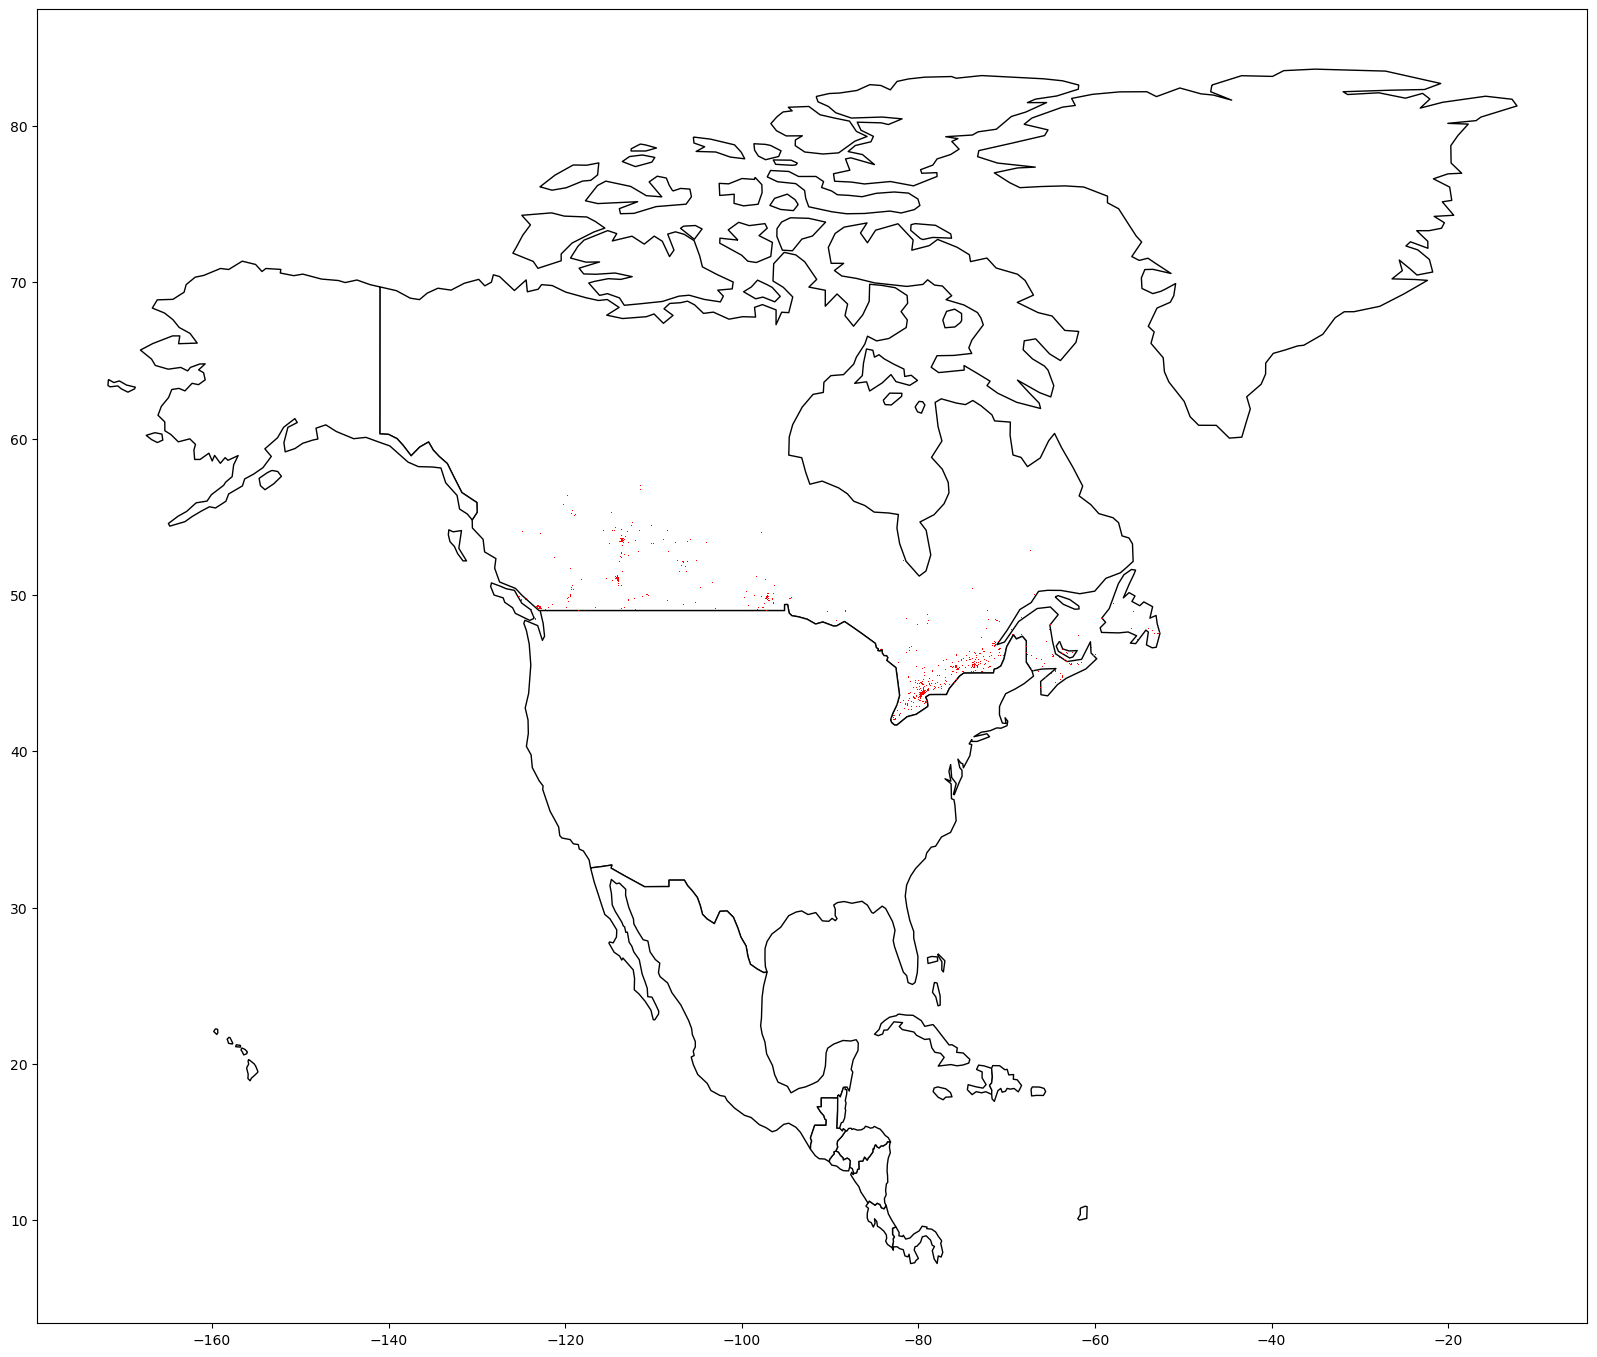

In [8]:
plt.rcParams["figure.figsize"] = (20,20)
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
speed_tiles.plot(ax=ax, color='red')

plt.show()

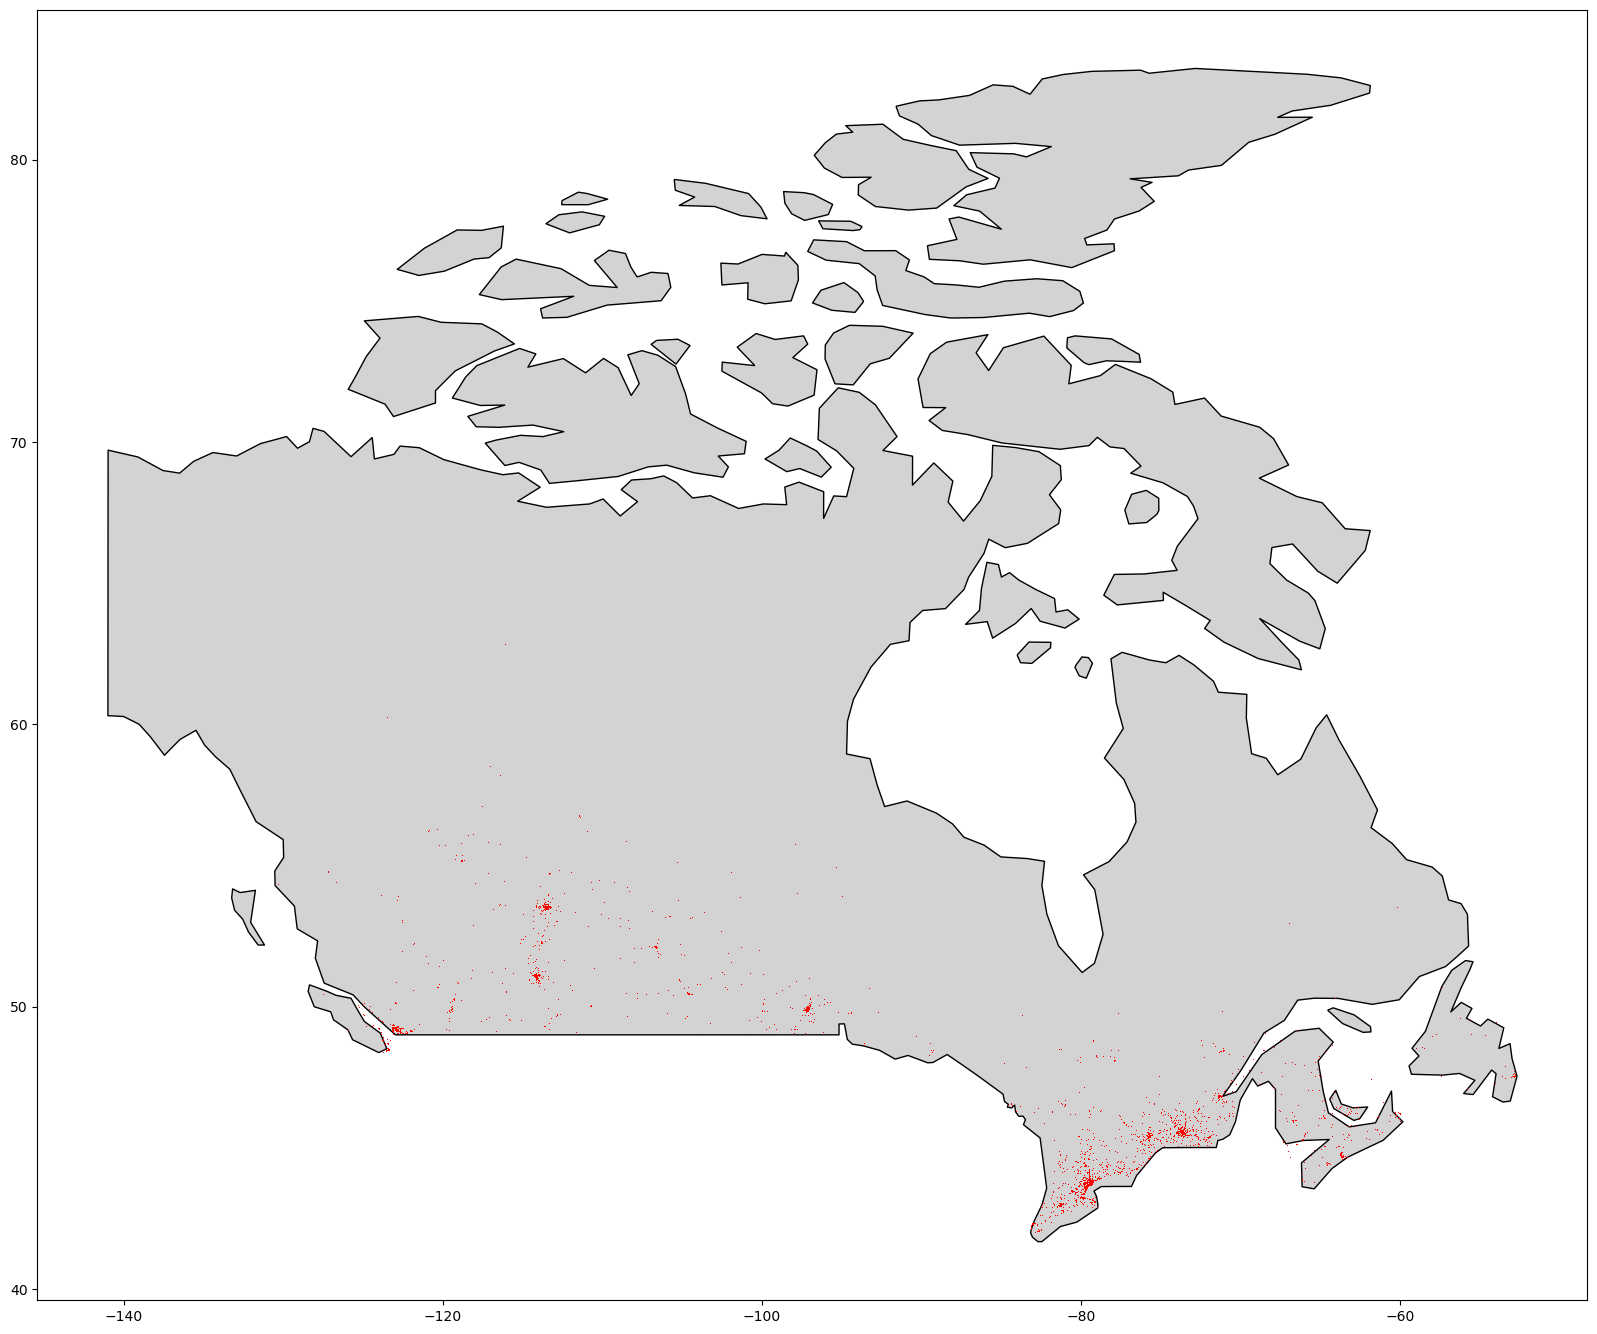

In [15]:
plt.rcParams["figure.figsize"] = (20,30)
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

# We restrict to Canada.
ax = world[world.name == 'Canada'].plot(
    color='lightgrey', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
speed_tiles.plot(ax=ax, color='red')

plt.show()

### Fixed vs Mobile

In [18]:
speed_tiles_fixed = speed_tiles.loc[lambda s:(s.conn_type == "fixed")]
speed_tiles_mobile = speed_tiles.loc[lambda s:(s.conn_type == "mobile")]

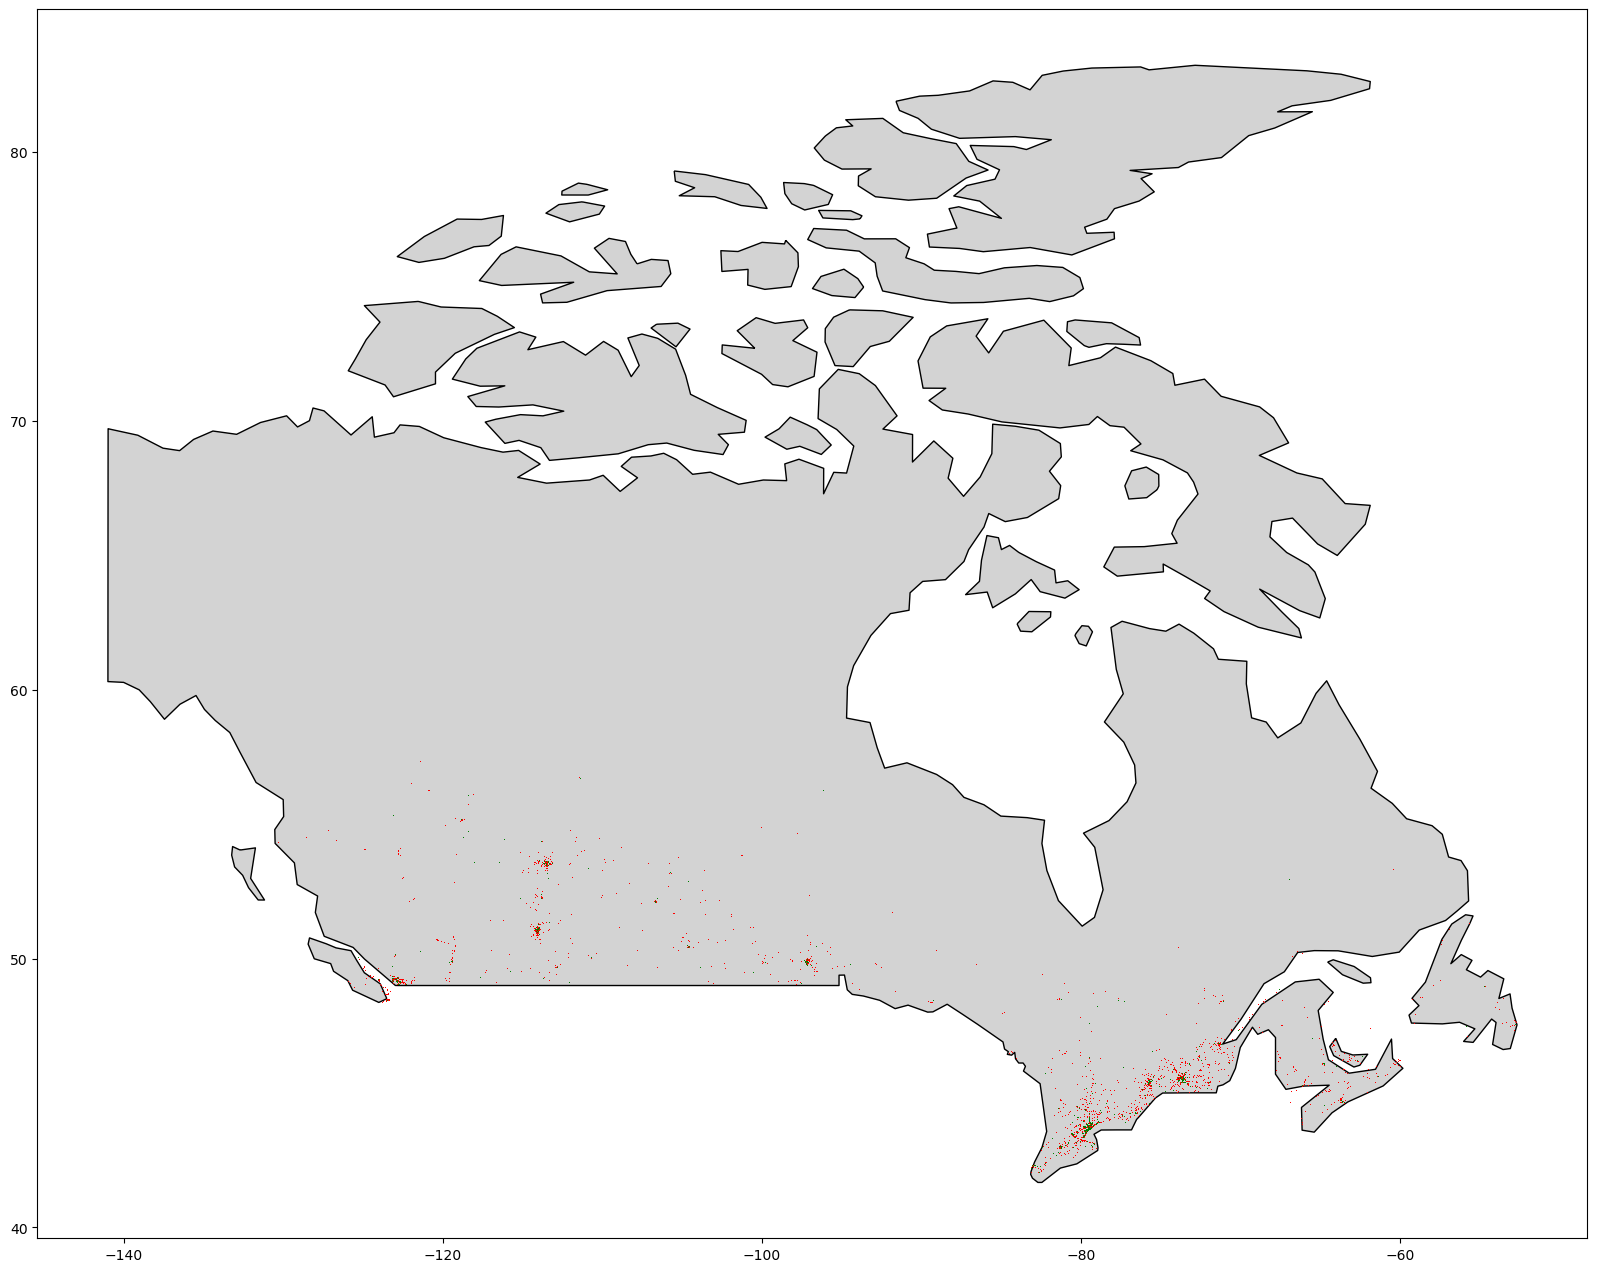

In [20]:
plt.rcParams["figure.figsize"] = (20,20)
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

# We restrict to Canada.
ax = world[world.name == 'Canada'].plot(
    color='lightgrey', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
speed_tiles_fixed.plot(ax=ax, color='red')
speed_tiles_mobile.plot(ax=ax, color='green')


plt.show()

### Edmonton Area

In [23]:
#Use a buffer to increase Edmonton size, envelope creates a bounding box for use later.
edmonton_area = statcan.boundary('population_centres').loc[lambda s:s.PCNAME=='Edmonton'].copy()
edmonton_area.geometry = edmonton_area.buffer(50000).envelope #The StatCan CRS is in units of meters, so this is all tiles within 50 km of Edmonton

In [24]:
nearby_census_subdivs = statcan.boundary('census_subdivisions').sjoin(edmonton_area[['PCNAME','PCTYPE','PCCLASS','geometry']], how='inner')
del nearby_census_subdivs['index_right']
nearby_census_subdivs.sample(3)

,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,...,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,geometry,PCNAME,PCTYPE,PCCLASS
4121,4811041,Point Alison,SV,48,Alberta,4811,Division No. 11,CDR,4811034,Parkland County,...,835,1,835,48835,Edmonton,B,"POLYGON ((4754779.191 2190595.983, 4754739.117...",Edmonton,1,4
3755,4813005,Val Quentin,SV,48,Alberta,4813,Division No. 13,CDR,4813001,Lac Ste. Anne County,...,999,7,None,None,None,None,"POLYGON ((4765524.263 2200867.277, 4765608.051...",Edmonton,1,4
4088,4811021,Thorsby,VL,48,Alberta,4811,Division No. 11,CDR,4811012,Leduc County,...,835,1,835,48835,Edmonton,B,"POLYGON ((4769316.557 2148772.786, 4769572.626...",Edmonton,1,4


<AxesSubplot: >

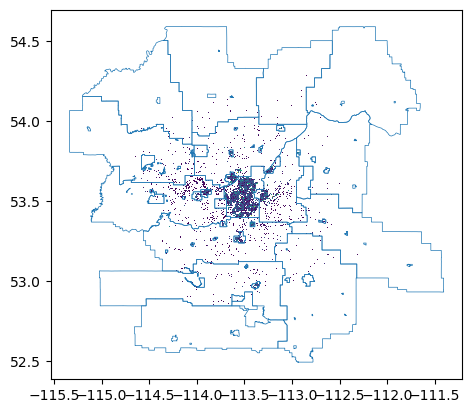

In [25]:
## the spatial join against the much wider areas of the census subdivisions 
## causes the default plotting area to be much wider than anticipated with the 
## Edmonton area geoemtry
nearby_speeds = speed_tiles.sjoin(edmonton_area.to_crs('epsg:4326'), how='inner') #epsg:4326
ax = nearby_speeds.plot(column='avg_d_kbps')
nearby_census_subdivs.to_crs('epsg:4326').boundary.plot(ax=ax, linewidth=0.5)

In [26]:
# Census Info
subdiv_pops = statcan.census_subdivisions_populations()
subdiv_pops.DAPOP = pd.to_numeric(subdiv_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
subdiv_pops

/home/ubuntu/src/datasets/loading/statcan.py:104: DtypeWarning: Columns (3,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(POP_FILE)


,CSDUID,GEO_NAME,DAPOP
381,1001105,"Portugal Cove South, T",150.0
635,1001113,"Trepassey, T",485.0
1016,1001120,"St. Shott's, T",65.0
1270,1001124,"Division No. 1, Subd. U, SNO",1625.0
1778,1001126,"Cape Broyle, T",490.0
...,...,...,...
7605014,6208047,"Kugaaruk, HAM",935.0
7605268,6208059,"Kugluktuk, HAM",1490.0
7605649,6208073,"Cambridge Bay, HAM",1770.0
7606157,6208081,"Gjoa Haven, HAM",1325.0


<AxesSubplot: >

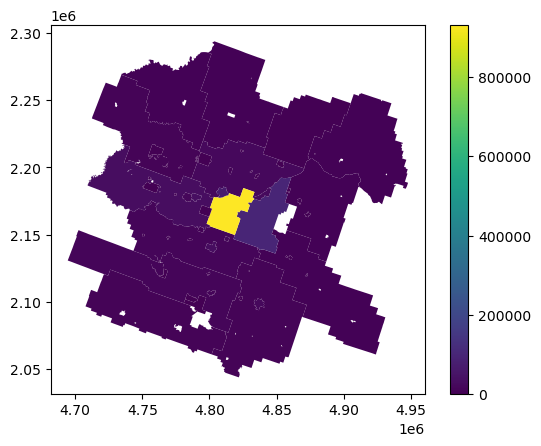

In [27]:
nearby_census_subdivs.CSDUID = nearby_census_subdivs.CSDUID.astype(int) ## coerce ID type to fully int instead of object
nearby_census_subdivs.merge(subdiv_pops, on='CSDUID', validate='1:1').plot(column='DAPOP', vmin=0, categorical=False, legend=True)

### Calgary Area

In [15]:
#Use a buffer to increase Calgary size, envelope creates a bounding box for use later.
calgary_area = statcan.boundary('population_centres').loc[lambda s:s.PCNAME=='Calgary'].copy()
calgary_area.geometry = calgary_area.buffer(50000).envelope #The StatCan CRS is in units of meters, so this is all tiles within 50 km of Calgary

In [16]:
nearby_census_subdivs = statcan.boundary('census_subdivisions').sjoin(calgary_area[['PCNAME','PCTYPE','PCCLASS','geometry']], how='inner')
del nearby_census_subdivs['index_right']
nearby_census_subdivs.sample(3)

,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,...,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,geometry,PCNAME,PCTYPE,PCCLASS
3965,4806024,Beiseker,VL,48,Alberta,4806,Division No. 6,CDR,4806014,Rocky View County,...,825,1,825,48825,Calgary,B,"POLYGON ((4731914.011 1946091.991, 4732673.223...",Calgary,1,4
4193,4815802,"Stoney 142, 143, 144",IRI,48,Alberta,4815,Division No. 15,CDR,4815015,Bighorn No. 8,...,997,5,None,None,None,None,"MULTIPOLYGON (((4633007.349 1968510.397, 46336...",Calgary,1,4
3966,4806026,Crossfield,T,48,Alberta,4806,Division No. 6,CDR,4806014,Rocky View County,...,825,1,825,48825,Calgary,B,"POLYGON ((4704505.594 1962796.526, 4703962.829...",Calgary,1,4


<AxesSubplot: >

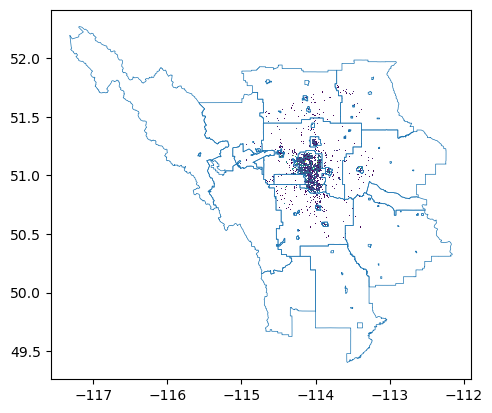

In [7]:
## the spatial join against the much wider areas of the census subdivisions 
## causes the default plotting area to be much wider than anticipated with the 
## calgary area geoemtry
nearby_speeds = speed_tiles.sjoin(calgary_area.to_crs('epsg:4326'), how='inner') #epsg:4326
ax = nearby_speeds.plot(column='avg_d_kbps')
nearby_census_subdivs.to_crs('epsg:4326').boundary.plot(ax=ax, linewidth=0.5)


### Census Info
Also some census data is available on populations.

In [8]:
subdiv_pops = statcan.census_subdivisions_populations()
subdiv_pops.DAPOP = pd.to_numeric(subdiv_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
subdiv_pops

/home/ubuntu/src/datasets/loading/statcan.py:104: DtypeWarning: Columns (3,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(POP_FILE)


,CSDUID,GEO_NAME,DAPOP
381,1001105,"Portugal Cove South, T",150.0
635,1001113,"Trepassey, T",485.0
1016,1001120,"St. Shott's, T",65.0
1270,1001124,"Division No. 1, Subd. U, SNO",1625.0
1778,1001126,"Cape Broyle, T",490.0
...,...,...,...
7605014,6208047,"Kugaaruk, HAM",935.0
7605268,6208059,"Kugluktuk, HAM",1490.0
7605649,6208073,"Cambridge Bay, HAM",1770.0
7606157,6208081,"Gjoa Haven, HAM",1325.0


<AxesSubplot: >

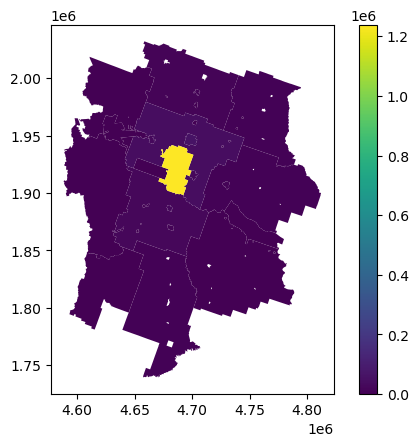

In [9]:
nearby_census_subdivs.CSDUID = nearby_census_subdivs.CSDUID.astype(int) ## coerce ID type to fully int instead of object
nearby_census_subdivs.merge(subdiv_pops, on='CSDUID', validate='1:1').plot(column='DAPOP', vmin=0, categorical=False, legend=True)

## Calculate Statistics

In [10]:
census_divs_speeds = statcan.boundary('census_divisions').to_crs('epsg:4326').sjoin(speed_tiles, how='left')

In [11]:
divs_pops = statcan.census_divisions_populations()
divs_pops.DAPOP = pd.to_numeric(divs_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
divs_pops


,CDUID,GEO_NAME,DAPOP
254,1001,Division No. 1,270345.0
72644,1002,Division No. 2,20375.0
83820,1003,Division No. 3,15560.0
92075,1004,Division No. 4,20385.0
99568,1005,Division No. 5,42015.0
...,...,...,...
7589774,6105,Region 5,6980.0
7592441,6106,Region 6,20090.0
7597775,6204,Baffin,18985.0
7602347,6205,Keewatin,10415.0


In [12]:
census_speeds_agg = (census_divs_speeds.groupby('CDUID')['avg_d_kbps'].mean()/1000).rename('avg_d_mpbs')

[Text(0.5, 37.61536509065093, 'Easting (m)'),
 Text(55.847222222222214, 0.5, 'Northing (m)')]

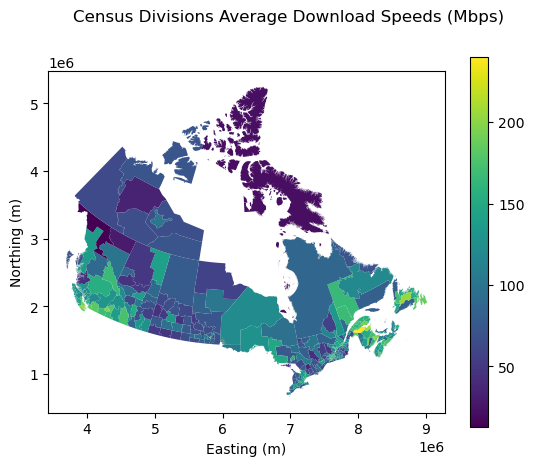

In [13]:
statcan.boundary('census_divisions').merge(census_speeds_agg, left_on="CDUID", right_index=True).plot(column='avg_d_mpbs', legend=True)
plt.gcf().suptitle("Census Divisions Average Download Speeds (Mbps)")
plt.gca().set(xlabel="Easting (m)", ylabel="Northing (m)")